# Histogram of difference of sequential frames as a proxy for change

This notebook shows the use of a histogram of the pixel-wise difference between sequential frames as a proxy for rate of change of the observed scattering signal, which itself may be used as a proxy for changes in the physical characteristics of the sample

In [1]:
from typing import Optional

from numpy import ndarray, dtype, integer, bool_, histogram, zeros, s_
from numpy.ma import  masked_where
from matplotlib.pyplot import figure, imshow
from matplotlib.colors import LogNorm

from adcorr.corrections import mask_frames
from sample_degradation.reading import map_frames, load_data

In [2]:
FILE_PATH = "/dls/i22/data/2022/sm30693-1/i22-623617.nxs"
FRAMES_KEY = "entry1/instrument/detector/data"
MASK_KEY = "entry1/instrument/detector/pixel_mask"

In [3]:
mask: ndarray[tuple[int, int], bool_] = load_data(FILE_PATH, MASK_KEY)

In [4]:
counts_list: list[ndarray[tuple[int], dtype[integer]]] = []
bounds_list: list[tuple[int, int]] = []

prior_masked_frame: Optional[ndarray] = None

for idx, frame in enumerate(map_frames(FILE_PATH, FRAMES_KEY)):
    masked_frame: ndarray = masked_where(mask, frame)
    if prior_masked_frame is not None:
        difference = masked_frame - prior_masked_frame
        counts, edges = histogram(difference, range(difference.min(), difference.max() + 1))
        counts_list.append(counts)
        bounds_list.append((edges[0], edges[-1]))
    prior_masked_frame = masked_frame
    

In [5]:
min_bound = min(bound[0] for bound in bounds_list)
max_bound = max(bound[1] for bound in bounds_list)

counts_map = zeros((len(counts_list), max_bound-min_bound), counts_list[0].dtype)

for idx, (counts, bounds) in enumerate(zip(counts_list, bounds_list)):
    counts_map[idx, (bounds[0] - min_bound):(bounds[1] - min_bound)] = counts

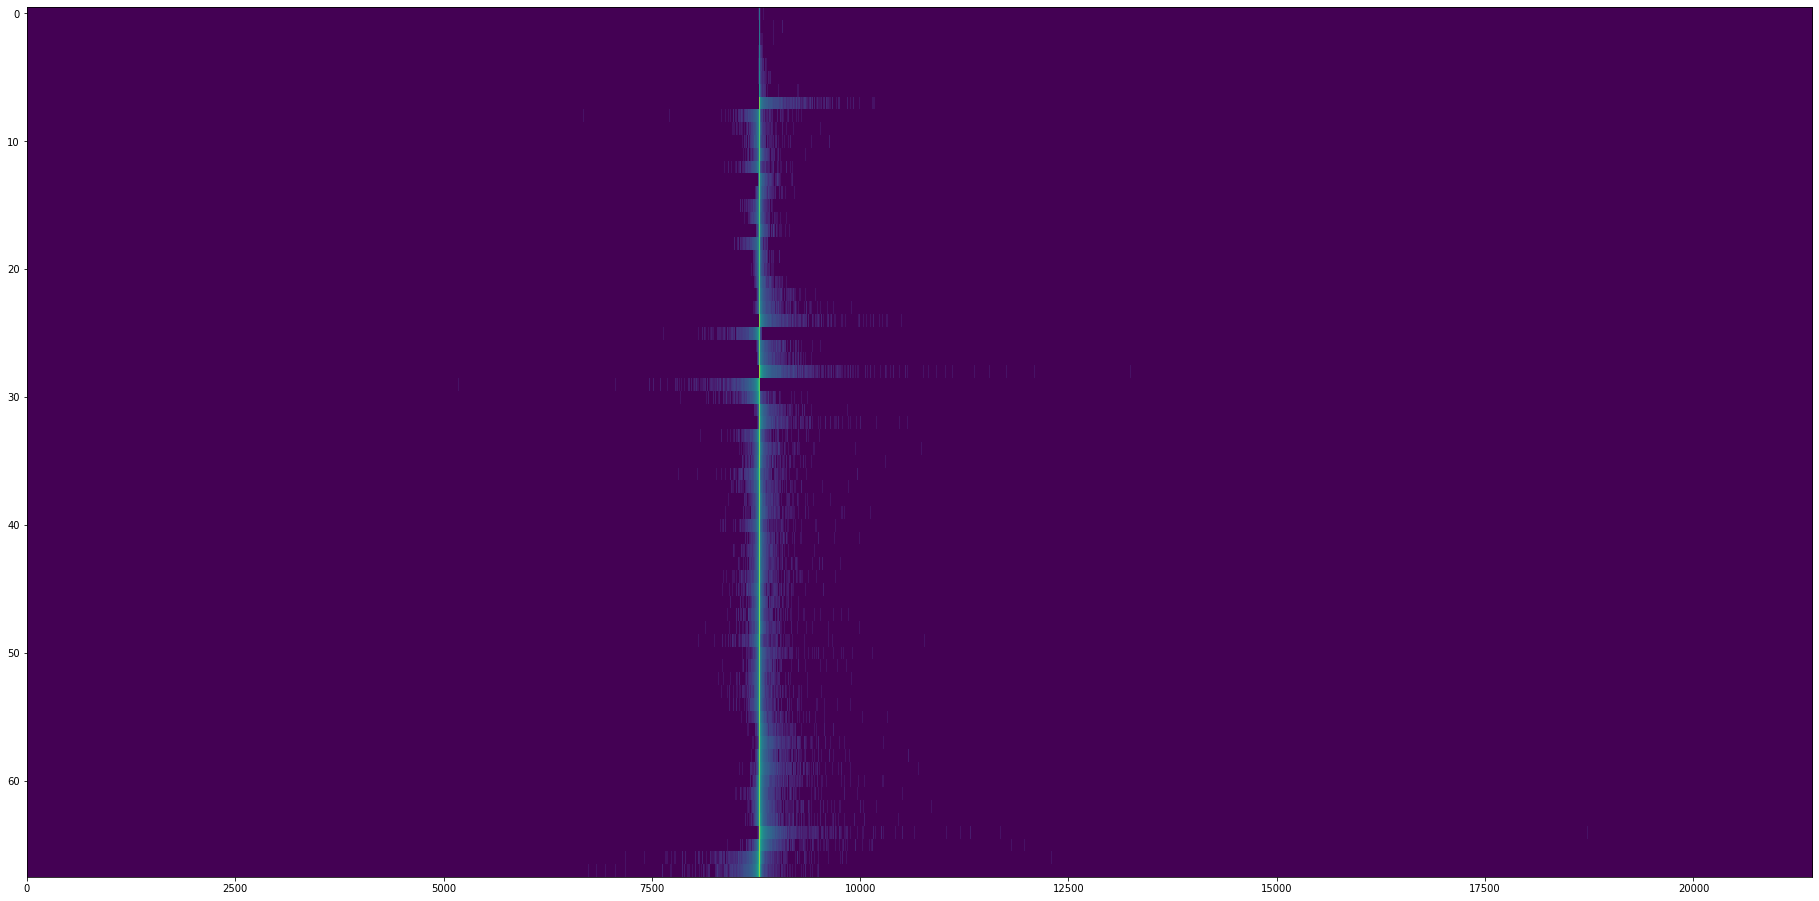

In [6]:
fig = figure(figsize=(32, 16))
imshow(counts_map, aspect='auto', interpolation='none', norm=LogNorm(clip=True))